Notebook exploring mutual information (MI) of toy data. 

## 2D binary data. First column of x is 'protected' and second column is not.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from mutual_info_analyser import MutualInfoAnalyser

In [2]:
def flip(x, p):
    """Function to flip second column of x with probability p"""
    assert x.ndim == 2, 'x must be 2D'
    assert x.shape[1] == 2, 'x should have two columns'
    xnew = copy.deepcopy(x)
    f = np.array([np.random.binomial(1, p) for _ in range(x.shape[0])])
    xnew[:, 1] = (x[:, 1]+f) % 2
    return xnew


def flip_continuous(x, p):
    """Function to randomize second column of x with probability p"""
    assert x.ndim == 2, 'x must be 2D'
    assert x.shape[1] == 2, 'x should have two columns'
    xnew = copy.deepcopy(x)
    for i in range(x.shape[0]):
        randomize = np.random.rand() < p
        if randomize:
            xnew[i, 1] = np.random.rand()
    return xnew

First look at MI between identical columns

In [27]:
N = 5000
x = np.array([np.random.binomial(1, 0.3) for _ in range(N)])[:, None]
x = np.concatenate((x, x), axis=1)

It's equal to 1

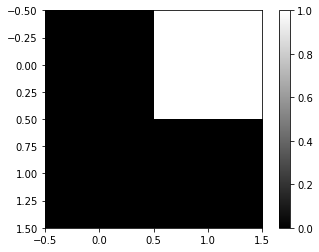

In [28]:
mia = MutualInfoAnalyser()
mia.add_dataframe(x)
mi = mia.mutual_info()
mia.plot_mutual_info(mi)
plt.savefig('./ims/binary_mi0.png')

Now flip elements of 2nd column with proability p and plot MI as function of p

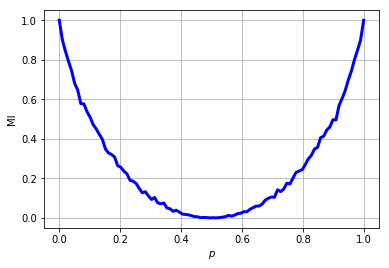

In [30]:
ps = np.linspace(0, 1, 100)
mi_base = []
for p in ps:
    xnew = flip(x, p)
    mia = MutualInfoAnalyser()
    mia.add_dataframe(xnew)
    mi = mia.mutual_info()
    mi_base.append(mi[0, 1])
mi_base = np.array(mi_base)

plt.plot(ps, mi_base,'b', lw=3)
plt.xlabel(r'$p$')
plt.ylabel('MI')
plt.grid()

A best fit function

In [6]:
f = interp1d(ps, mi_base)

Now suppose at the start our 2nd column is not fully associated with 1st column.

In [7]:
p_flip0 = 0.3
x2 = flip(x, p_flip0)

The MI is considerably reduced

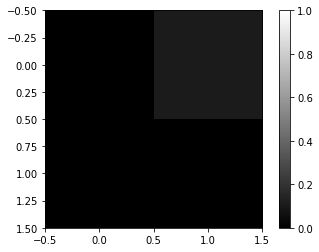

In [8]:
mia = MutualInfoAnalyser()
mia.add_dataframe(x2)
mi = mia.mutual_info()
mia.plot_mutual_info(mi)
mi0 = mi[0, 1]

Now plot MI as function of p

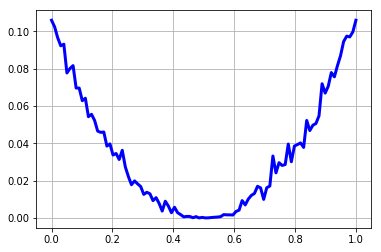

In [9]:
mis = []
for p in ps:
    xnew = flip(x2, p)
    mia = MutualInfoAnalyser()
    mia.add_dataframe(xnew)
    mi = mia.mutual_info()
    mis.append(mi[0, 1])
mis = np.array(mis)
    
plt.plot(ps, mis, 'b', lw=3)
plt.grid()

Does MI change by same proportions with p? If so below curves should overlap or at least be very close. Generally seems pretty good(?)

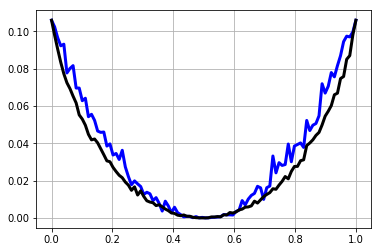

In [10]:
plt.plot(ps, mis, 'b', lw=3)
plt.plot(ps, mi_base*mi0, 'k', lw=3)
plt.grid()

## Continuous data

Now lets do the same with 'continuous data'

In [11]:
x = np.random.rand(N)[:, None]
x = np.concatenate((x, x), axis=1)

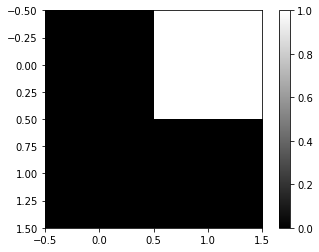

In [12]:
mia = MutualInfoAnalyser()
mia.add_dataframe(x)
mia.discretize_dataframe(n_bins=20)
mi = mia.mutual_info()
mia.plot_mutual_info(mi)

The behavious is very different

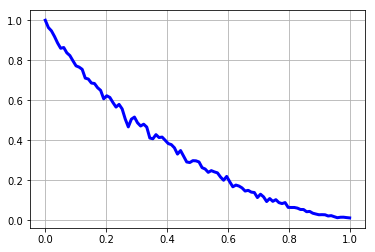

In [13]:
ps = np.linspace(0, 1, 100)
mi_base = []
for p in ps:
    xnew = flip_continuous(x, p)
    mia = MutualInfoAnalyser()
    mia.add_dataframe(xnew)
    mia.discretize_dataframe(n_bins=20)
    mi = mia.mutual_info()
    mi_base.append(mi[0, 1])
mi_base = np.array(mi_base)

plt.plot(ps, mi_base,'b', lw=3)
plt.grid()

A best fit function

In [14]:
f = interp1d(ps, mi_base)

Now suppose at the start our 2nd column is not fully associated with 1st column.

In [15]:
p_flip0 = 0.3
x2 = flip_continuous(x, p_flip0)

The MI is considerably reduced

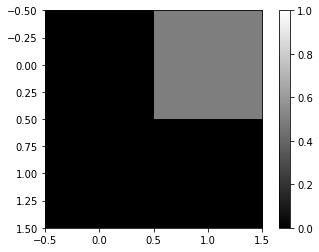

In [16]:
mia = MutualInfoAnalyser()
mia.add_dataframe(x2)
mia.discretize_dataframe(n_bins=20)
mi = mia.mutual_info()
mia.plot_mutual_info(mi)
mi0 = mi[0, 1]

Now plot MI as function of p

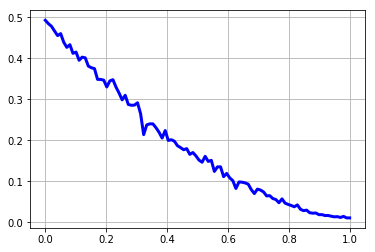

In [17]:
mis = []
for p in ps:
    xnew = flip_continuous(x2, p)
    mia = MutualInfoAnalyser()
    mia.add_dataframe(xnew)
    mia.discretize_dataframe(n_bins=20)
    mi = mia.mutual_info()
    mis.append(mi[0, 1])
mis = np.array(mis)
    
plt.plot(ps, mis, 'b', lw=3)
plt.grid()

Does MI change by same proportions with p? If so below curves should overlap or at least be very close. Generally seems pretty good(?)

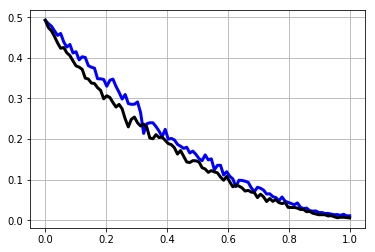

In [18]:
plt.plot(ps, mis, 'b', lw=3)
plt.plot(ps, mi_base*mi0, 'k', lw=3)
plt.grid()

Lets make some labels:

In [19]:
y = x2[:, 0]**2 - 0.5*x2[:, 1] + 0.1*np.random.randn(N) > 0 # case protected variable most important
# y = -0.5*x2[:, 0] + x2[:, 1]**2 + 0.1*np.random.randn(N) > 0 # case unprotected variable most important
print(y)
print(sum(y))

[False  True  True ... False  True False]
2937


Prediction using protected and not protected:

In [20]:
scores = cross_val_score(RandomForestClassifier(
    n_estimators=50), x2, y, cv=10)
print(scores)
print(np.mean(scores))

[0.73253493 0.75648703 0.75249501 0.728      0.762      0.742
 0.748      0.72144289 0.75951904 0.74348697]
0.7445965863863455


Prediction using only not protected:

In [21]:
scores = cross_val_score(RandomForestClassifier(
    n_estimators=50), x2[:, 1][:, None], y, cv=10)
print(scores)
print(np.mean(scores))

[0.59081836 0.54491018 0.56686627 0.518      0.584      0.568
 0.572      0.50701403 0.56112224 0.5751503 ]
0.5587881383525534


In [22]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(x2, y)
forest.feature_importances_

array([0.64019809, 0.35980191])

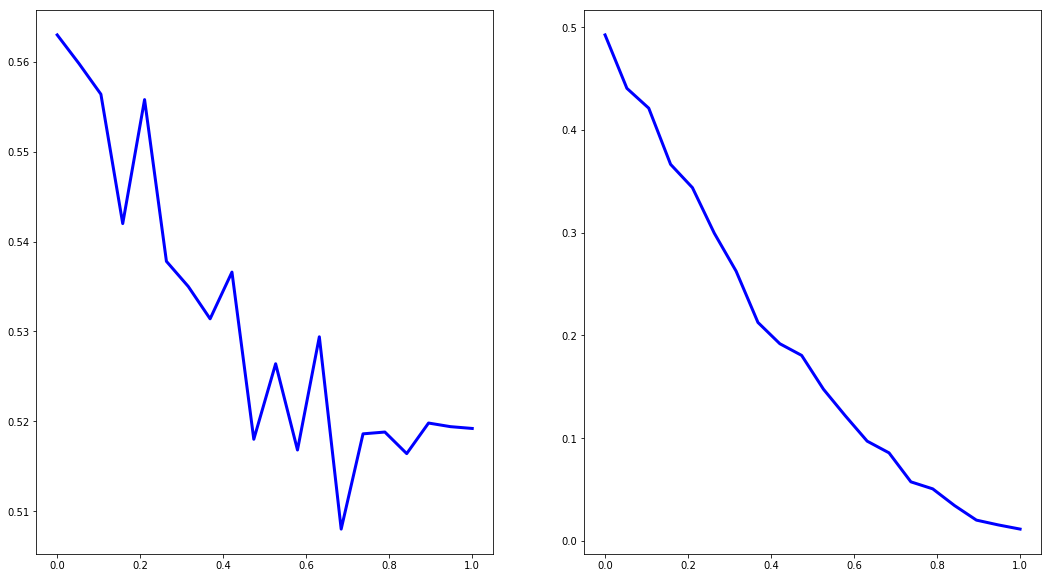

In [23]:
accs = []
mis = []
ps = np.linspace(0, 1, 20)

for p in ps:
    xnew = flip_continuous(x2, p)
    scores = cross_val_score(RandomForestClassifier(
        n_estimators=50), xnew[:, 1][:, None], y, cv=3)
    score = np.mean(scores)
    accs.append(score)
    mia = MutualInfoAnalyser()
    mia.add_dataframe(xnew)
    mia.discretize_dataframe(n_bins=20)
    mi = mia.mutual_info()
    mis.append(mi[0, 1])
mis = np.array(mis)

plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.plot(ps, accs, 'b', lw=3)
plt.subplot(1,2,2)
plt.plot(ps, mis, 'b', lw=3)

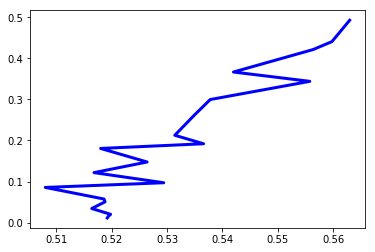

In [24]:
plt.plot(accs, mis, 'b', lw=3)